In [1]:
import re
import en_core_web_lg  
from collections import Counter
from collections import defaultdict
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import wordninja    
import sys
import os
from datetime import datetime
from tqdm import tqdm
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from knowledge_layer import KnowledgeGroupLayer
from itertools import groupby
from collections import Counter
import numpy as np
from thefuzz import fuzz
import itertools 

input_dir = '../logs/' # The input directory of log file
output_dir = 'LogParserResult/' # The output directory of parsing results

In [2]:
def remove_repeated(val):
  x = val.split(" ")
  str_list = list(filter(None, x))
  clean = [i[0] for i in groupby(str_list)]
  return ' '.join(clean)

def preprocess_document(document):
    dic_debug = {}
    nlp =en_core_web_lg.load()
    # log_list =  [re.sub(r"[^A-Za-z]+", ' ', _) for _ in document]
    for log in document:
        splitted_log = wordninja.split(log)
        remove_urls = re.sub('[^ ]+\.[^ ]+','<*>',' '.join(splitted_log) )
        
        remove_float = re.sub("(\d*\.\d+)|(\d+\.[0-9 ]+)", "<*>", remove_urls) 
        remove_int = re.sub(r'\d+', "<*>", remove_float )
        generic_str = re.sub(r'\b\w{1,2}\b', '', remove_int) 

        dic_debug[log]  = remove_repeated(generic_str)
    logs_clean =dic_debug.values()
    return logs_clean


In [3]:
def compute_generic_string(dataset):
    # edge case where all strings are the same
    if len(set(dataset))==1:
        return dataset[0]
    commonprefix = os.path.commonprefix(dataset)

    return "{}<*> {}".format(commonprefix,os.path.commonprefix([s[len(commonprefix):][::-1] for s in dataset])[::-1])

In [8]:
def remove_repeated(val):
  x = val.split(" ")
  str_list = list(filter(None, x))
  clean = [i[0] for i in groupby(str_list)]
  return ' '.join(clean)

In [4]:
def transform_wildcard(document):
    print("in wild card step")
    logs_clean =list(set(document)) #remove repeated logs
    
    logs_dict = {}
    for doc1, doc2 in tqdm(itertools.combinations(logs_clean, 2), desc='processing similar logs'):

        pair = [doc1, doc2]
        ratio = fuzz.ratio(doc1,doc2)
        if ratio > 70:
            c = compute_generic_string(pair)
            # generic_str = re.sub(r'\b\w{1,2}\b', '', c)
            
            if c not in logs_dict.values():
                p_string = remove_repeated(c)
                logs_dict[doc1] = p_string
                logs_dict[doc2] = p_string
                
        else:   
            if doc1 not in logs_dict.keys():
                logs_dict[doc1] = remove_repeated(doc1)
            
            if doc2 not in logs_dict.keys():
                logs_dict[doc2] = remove_repeated(doc2)
        
    return list(set(logs_dict.values()))

temp = ['Block broadcast_9 stored as values in memory (estimated size 8.8 KB, free 14.0 KB)',
'Block broadcast_8 stored as values in memory (estimated size 281.6 KB, free 317.0 KB)',
'Block broadcast_2 stored as values in memory (estimated size 384.0 B, free 319.4 KB)',
'Block broadcast_12 stored as values in memory (estimated size 9.8 KB, free 369.3 KB)',
"Saved output of task 'attempt_201706092018_0024_m_000003_1012' to hdfs://10.10.34.11:9000/pjhe/test/1/_temporary/0/task_201706092018_0024_m_000003" ]
pdoc = preprocess_document(temp)
transform_wildcard(pdoc)

processing similar logs: 1it [00:00, ?it/s]

in wild card step


["Saved output task ' attempt <*> ' hdf <*> test <*> temporary <*> task <*>",
 'Block broadcast <*> stored values memory estimated size <*> free <*>']

In [5]:
def get_relations(document):
    
    # in our case, relations are bigrams in sentences
    bigrams = []
    nlp = en_core_web_lg.load()
    # for sent in document:

    new_dict = {}
    for doc1, doc2 in itertools.combinations(document, 2):   
        if doc1 != doc2:
            pdoc1 = re.sub('[^a-zA-Z0-9]+', ' ', doc1)
            pdoc2 = re.sub('[^a-zA-Z0-9]+', ' ', doc2)

            pair = [doc1,doc2]
            pdoc1 = nlp(pdoc1)
            pdoc2 = nlp( pdoc2)
        # only add unique bigrams
            similarity =pdoc1.similarity(pdoc2) 
            ratio = fuzz.ratio(doc1,doc2)
            print(pair, similarity, ratio)
            if similarity > 0.7 or ratio > 70:
                
                if pair not in bigrams:
                    bigrams.append(pair)

    return bigrams

In [6]:
def load_logs(log_file, regex, headers):
    """ Function to transform log file to dataframe
    """
    log_messages = dict()
    linecount = 0
    with open(log_file, 'r') as fin:
        for line in tqdm(fin.readlines(), desc='load data'):
            try:
                linecount += 1
                match = regex.search(line.strip())
                message = dict()
                for header in headers:
                    message[header] = match.group(header)
                message['LineId'] = linecount
                log_messages[linecount] = message
            except Exception as e:
                pass
    return log_messages

In [7]:
benchmark_settings = {
    'HDFS': {
        'log_file': 'HDFS/HDFS_2k.log',
        'log_format': '<Date> <Time> <Pid> <Level> <Component>: <Content>',
        },
         'claudia': {
        'log_file': 'HDFS/HDFS_2k.log',
        'log_format': '<Date> <Time> <Pid> <Level> <Component>: <Content>',
        },

    'Hadoop': {
        'log_file': 'Hadoop/Hadoop_2k.log',
        'log_format': '<Date> <Time> <Level> \[<Process>\] <Component>: <Content>', 
        },

    'Spark': {
        'log_file': 'Spark/Spark_2k.log',
        'log_format': '<Date> <Time> <Level> <Component>: <Content>', 
        },

    'Zookeeper': {
        'log_file': 'Zookeeper/Zookeeper_2k.log',
        'log_format': '<Date> <Time> - <Level>  \[<Node>:<Component>@<Id>\] - <Content>',
        },

    'BGL': {
        'log_file': 'BGL/BGL_2k.log',
        'log_format': '<Label> <Timestamp> <Date> <Node> <Time> <NodeRepeat> <Type> <Component> <Level> <Content>',
        },

    'HPC': {
        'log_file': 'HPC/HPC_2k.log',
        'log_format': '<LogId> <Node> <Component> <State> <Time> <Flag> <Content>',
        },

    'Thunderbird': {
        'log_file': 'Thunderbird/Thunderbird_2k.log',
        'log_format': '<Label> <Timestamp> <Date> <User> <Month> <Day> <Time> <Location> <Component>(\[<PID>\])?: <Content>',
        },

    'Windows': {
        'log_file': 'Windows/Windows_2k.log',
        'log_format': '<Date> <Time>, <Level>                  <Component>    <Content>',
        },

    'Linux': {
        'log_file': 'Linux/Linux_2k.log',
        'log_format': '<Month> <Date> <Time> <Level> <Component>(\[<PID>\])?: <Content>',
        },

    'Andriod': {
        'log_file': 'Andriod/Andriod_2k.log',
        'log_format': '<Date> <Time>  <Pid>  <Tid> <Level> <Component>: <Content>',
        },

    'HealthApp': {
        'log_file': 'HealthApp/HealthApp_2k.log',
        'log_format': '<Time>\|<Component>\|<Pid>\|<Content>',
        },

    'Apache': {
        'log_file': 'Apache/Apache_2k.log',
        'log_format': '\[<Time>\] \[<Level>\] <Content>',
        },

    'Proxifier': {
        'log_file': 'Proxifier/Proxifier_2k.log',
        'log_format': '\[<Time>\] <Program> - <Content>',
        },


    'OpenSSH': {
        'log_file': 'OpenSSH/OpenSSH_2k.log',
        'log_format': '<Date> <Day> <Time> <Component> sshd\[<Pid>\]: <Content>',
        },

    'OpenStack': {
        'log_file': 'OpenStack/OpenStack_2k.log',
        'log_format': '<Logrecord> <Date> <Time> <Pid> <Level> <Component> \[<ADDR>\] <Content>',
        },
        
    'Mac': {
        'log_file': 'Mac/Mac_2k.log',
        'log_format': '<Month>  <Date> <Time> <User> <Component>\[<PID>\]( \(<Address>\))?: <Content>',
        }
}

In [8]:
def generate_logformat_regex(logformat):
    """ Function to generate regular expression to split log messages
    """
    headers = []
    splitters = re.split(r'(<[^<>]+>)', logformat)
    regex = ''
    for k in range(len(splitters)):
        if k % 2 == 0:
            splitter = re.sub(' +', '\\\s+', splitters[k])
            regex += splitter
        else:
            header = splitters[k].strip('<').strip('>')
            regex += '(?P<%s>.*?)' % header
            headers.append(header)
    regex = re.compile('^' + regex + '$')
    return headers, regex

In [9]:
def plot_graph(G, title=None):
    # set figure size
    plt.figure(figsize=(10,10))

    # define position of nodes in figure
    # G= nx.convert_node_labels_to_integers(G, first_label=0)

    pos = nx.nx_agraph.graphviz_layout(G)
    # draw nodes and edges
    nx.draw(G, pos=pos, with_labels=True)

    # get edge labels (if any)
    edge_labels = nx.get_edge_attributes(G, 'weight')

    # draw edge labels (if any)
    # nx.draw_networkx_nodes(G, pos, edge_labels=edge_labels)
    nx.draw_networkx_nodes(G,pos)
    # plot the title (if any)
    plt.title(dataset+ ' Logs')

    plt.show()
    return

In [10]:
def build_graph(doc):
    # preprocess document for standardization
    pdoc = preprocess_document(doc)
    # get graph nodes
    # df = co_occurrence(pdoc, 2)
    pdoc = transform_wildcard(pdoc)
    
    # print(pdoc)
    # get graph edges
    if '<*>' in pdoc:
        pdoc.remove('<*>')
    edges = get_relations(pdoc)
    # nodes = log_transformer(pdoc)
    # create graph structure with NetworkX
    G = nx.Graph()
    G.add_nodes_from(pdoc )
    atrributes = Counter(pdoc)
    nx.set_node_attributes(G, atrributes, "count")
    # G.remove_node('idf_weights')
    G.add_edges_from(edges)
    G.remove_edges_from(nx.selfloop_edges(G))
    
    return G

In [11]:
from knowledge_layer import KnowledgeGroupLayer
dataset = 'HDFS'
filepath = '../../logs/'+ benchmark_settings[dataset]['log_file']
print('Parsing file: ' + filepath)
starttime = datetime.now()
headers, regex = generate_logformat_regex(benchmark_settings[dataset]['log_format'])
log_messages = load_logs(filepath, regex, headers)
log_messages = KnowledgeGroupLayer(log_messages).run()
# log_messages = DictGroupLayer(log_messages).run()
# preprocess layer
list_dict = log_messages.values()
empty_dict = {}
logs = [d.get('Content', None) for d in list_dict]

# print(logs[0:2])
G = build_graph(logs)


priori knowledge preprocess: 100%|██████████| 2000/2000 [00:00<00:00, 33429.67it/s]

Parsing file: ../../logs/HDFS/HDFS_2k.log
Knowledge group layer finished.



processing similar logs: 190it [00:00, 184856.82it/s]

in wild card step


['Starting thread transfer block <*>', 'BLOCK ask replicate <*> data node'] 0.5369961783798238 33
['Starting thread transfer block <*>', 'Deleting block <*> file had oop data current <*>'] 0.7161886977483173 41
['Starting thread transfer block <*>', 'BLOCK ask delete <*>'] 0.20940358762679867 33
['Starting thread transfer block <*>', 'BLOCK Name System add Stored Block block Map updated added <*> size <*>'] 0.6040143590974598 38
['Starting thread transfer block <*>', 'Packet Responder <*> for block <*> terminating'] 0.7719083311156957 45
['Starting thread transfer block <*>', 'Got exception while serving <*>'] 0.5325208420937951 46
['Starting thread transfer block <*>', 'Received block <*> size <*><*>'] 0.6693729174900706 41
['Starting thread transfer block <*>', 'BLOCK Name System allocate Block user root rand txt <*> temporary task <*> part <*>'] 0.6927816364110692 34
['Starting thread transfer block <*>', 'BLOCK Name System delete <*> added invalid Set'] 0.4540783721901345 28
['Star

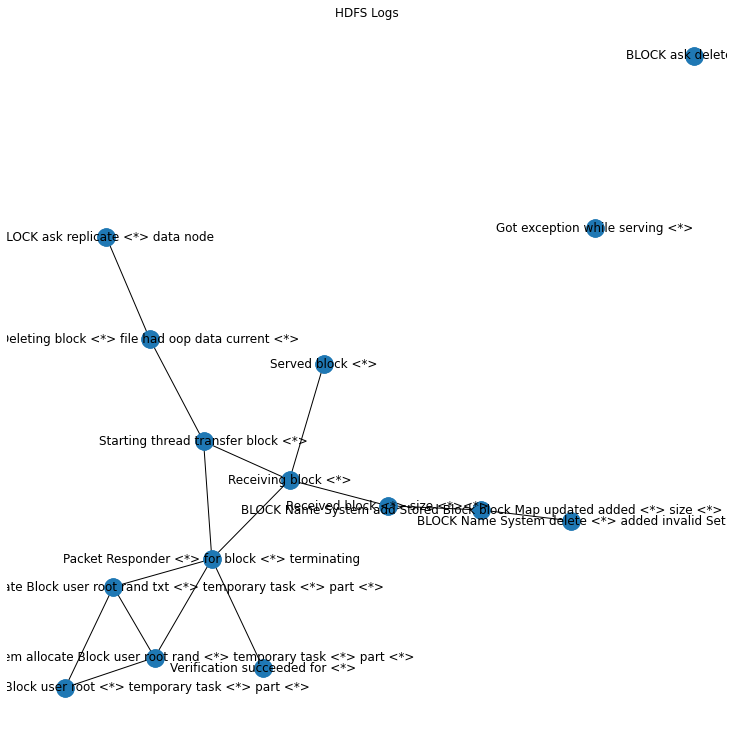

In [12]:
plot_graph(G)

In [13]:
nx.write_gpickle(G,dataset+'sim.gpickle')

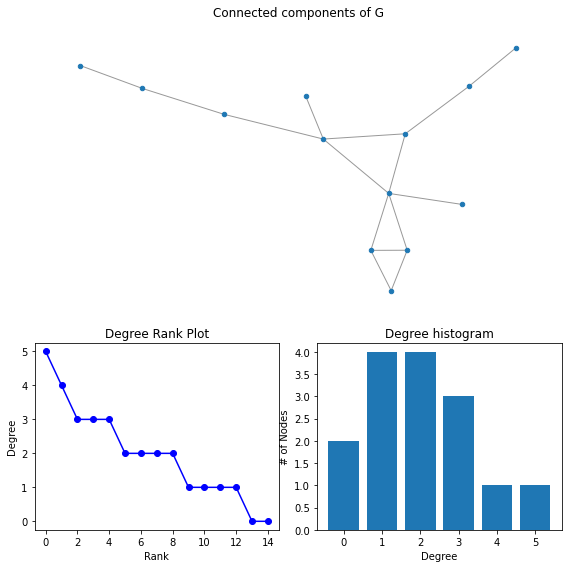

In [14]:

degree_sequence = sorted((d for n, d in G.degree()), reverse=True)
dmax = max(degree_sequence)

fig = plt.figure("Degree of graph", figsize=(8, 8))
# Create a gridspec for adding subplots of different sizes
axgrid = fig.add_gridspec(5, 4)

ax0 = fig.add_subplot(axgrid[0:3, :])
Gcc = G.subgraph(sorted(nx.connected_components(G), key=len, reverse=True)[0])
pos = nx.spring_layout(Gcc, seed=10396953)
nx.draw_networkx_nodes(Gcc, pos, ax=ax0, node_size=20)
nx.draw_networkx_edges(Gcc, pos, ax=ax0, alpha=0.4)
ax0.set_title("Connected components of G")
ax0.set_axis_off()

ax1 = fig.add_subplot(axgrid[3:, :2])
ax1.plot(degree_sequence, "b-", marker="o")
ax1.set_title("Degree Rank Plot")
ax1.set_ylabel("Degree")
ax1.set_xlabel("Rank")

ax2 = fig.add_subplot(axgrid[3:, 2:])
ax2.bar(*np.unique(degree_sequence, return_counts=True))
ax2.set_title("Degree histogram")
ax2.set_xlabel("Degree")
ax2.set_ylabel("# of Nodes")

fig.tight_layout()
plt.show()

In [16]:
from networkx.algorithms.community import greedy_modularity_communities
c = greedy_modularity_communities(G)
c[0]

frozenset({'BLOCK Name System allocate Block user root <*> temporary task <*> part <*>',
           'BLOCK Name System allocate Block user root rand <*> temporary task <*> part <*>',
           'BLOCK Name System allocate Block user root rand txt <*> temporary task <*> part <*>',
           'Packet Responder <*> for block <*> terminating',
           'Verification succeeded for <*>'})

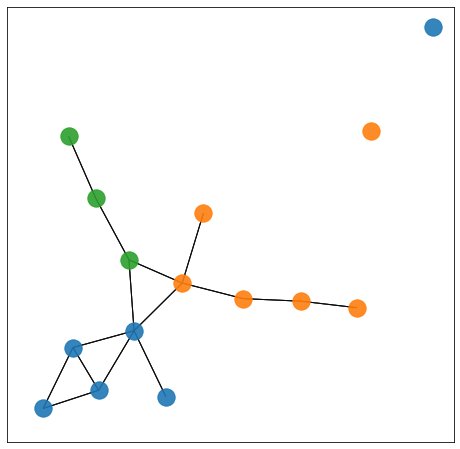

In [17]:

# list of detected communities 
c = list(greedy_modularity_communities(G))
sortedCommunities = []

# iterate through list of discovered communities. Sort each community and add them to new list.

for community in c:
    sortedCommunities.append(sorted(community))

# draw community
# here we are using a different color at each iteration but cycling back to the first color.

community_to_color = {
    0 : 'tab:blue',
    1 : 'tab:orange',
    2 : 'tab:green',
    3 : 'tab:red',
}
temp_counter = 0
pos = nx.nx_agraph.graphviz_layout(G)
# color = [subset_color[data["layer"]] for v, data in G.nodes(data=True)]
# pos = nx.multipartite_layout(G, subset_key="layer")
plt.figure(figsize=(8, 8))
for community in sortedCommunities:
    
    chosenColor = community_to_color[temp_counter%3]
    temp_counter += 1
    nx.draw_networkx_nodes(G,pos, nodelist=community ,label=True, node_color=chosenColor , alpha=0.9)
    nx.draw_networkx_edges(G,pos ,alpha=0.5)
plt.show()

In [18]:
sortedCommunities

[['BLOCK Name System allocate Block user root <*> temporary task <*> part <*>',
  'BLOCK Name System allocate Block user root rand <*> temporary task <*> part <*>',
  'BLOCK Name System allocate Block user root rand txt <*> temporary task <*> part <*>',
  'Packet Responder <*> for block <*> terminating',
  'Verification succeeded for <*>'],
 ['BLOCK Name System add Stored Block block Map updated added <*> size <*>',
  'BLOCK Name System delete <*> added invalid Set',
  'Received block <*> size <*><*>',
  'Receiving block <*>',
  'Served block <*>'],
 ['BLOCK ask replicate <*> data node',
  'Deleting block <*> file had oop data current <*>',
  'Starting thread transfer block <*>'],
 ['BLOCK ask delete <*>'],
 ['Got exception while serving <*>']]

In [19]:
print(nx.info(G))

Graph with 15 nodes and 15 edges


In [20]:
from node2vec import Node2Vec as n2v

g_emb = n2v(G, dimensions=16)

WINDOW = 1 # Node2Vec fit window
MIN_COUNT = 1 # Node2Vec min. count
BATCH_WORDS = 4 # Node2Vec batch words

mdl = g_emb.fit(
    window=WINDOW,
    min_count=MIN_COUNT,
    batch_words=BATCH_WORDS
)

emb_df = (
    pd.DataFrame(
        [mdl.wv.get_vector(str(n)) for n in G.nodes()],
        index = list(G.nodes())
    )
)


emb_df.head()

print(emb_df.head())

Generating walks (CPU: 1): 100%|██████████| 10/10 [00:00<00:00, 26.70it/s]


                                                          0         1   \
Starting thread transfer block <*>                  0.193400  0.758613   
BLOCK ask replicate <*> data node                   0.221567  0.834394   
Deleting block <*> file had oop data current <*>    0.185579  0.806691   
BLOCK ask delete <*>                               -0.006290 -0.028005   
BLOCK Name System add Stored Block block Map up...  0.739139  0.943896   

                                                          2         3   \
Starting thread transfer block <*>                  0.369111 -0.009556   
BLOCK ask replicate <*> data node                   0.429144 -0.182849   
Deleting block <*> file had oop data current <*>    0.467003 -0.132159   
BLOCK ask delete <*>                               -0.004316 -0.019027   
BLOCK Name System add Stored Block block Map up...  0.067901 -0.425514   

                                                          4         5   \
Starting thread transfer block <*>  

In [21]:
WINDOW = 1 # Node2Vec fit window
MIN_COUNT = 1 # Node2Vec min. count
BATCH_WORDS = 4 # Node2Vec batch words

g_emb = n2v(
  G,
  dimensions=16
)

mdl = g_emb.fit(
    window=WINDOW,
    min_count=MIN_COUNT,
    batch_words=BATCH_WORDS
)

input_node = 'BLOCK ask replicate <*> data node'
for s in mdl.wv.most_similar(input_node, topn = 10):
    print(s)

Generating walks (CPU: 1): 100%|██████████| 10/10 [00:00<00:00, 23.90it/s]


('Deleting block <*> file had oop data current <*>', 0.9950016140937805)
('Starting thread transfer block <*>', 0.917259931564331)
('Receiving block <*>', 0.8216996192932129)
('Verification succeeded for <*>', 0.8030728101730347)
('Packet Responder <*> for block <*> terminating', 0.7662699222564697)
('Served block <*>', 0.7466951012611389)
('BLOCK Name System allocate Block user root rand <*> temporary task <*> part <*>', 0.6140590906143188)
('BLOCK Name System allocate Block user root <*> temporary task <*> part <*>', 0.6032751202583313)
('BLOCK Name System allocate Block user root rand txt <*> temporary task <*> part <*>', 0.600222110748291)
('Received block <*> size <*><*>', 0.5369808077812195)


[]

<Figure size 432x288 with 0 Axes>

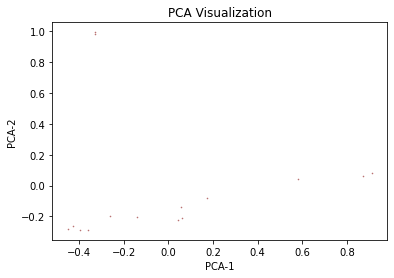

In [118]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 2, random_state = 7)
pca_mdl = pca.fit_transform(emb_df)

emb_df_PCA = (
    pd.DataFrame(
        pca_mdl,
        columns=['x','y'],
        index = emb_df.index
    )
)
plt.clf()
fig = plt.figure(figsize=(6,4))
plt.scatter(
    x = emb_df_PCA['x'],
    y = emb_df_PCA['y'],
    s = 0.4,
    color = 'maroon',
    alpha = 0.5
)
plt.xlabel('PCA-1')
plt.ylabel('PCA-2')
plt.title('PCA Visualization')
plt.plot()

In [39]:

from math import isclose
from sklearn.decomposition import PCA
import os
import networkx as nx
import numpy as np
import pandas as pd
from stellargraph import StellarGraph, datasets
from stellargraph.data import EdgeSplitter
from collections import Counter
import multiprocessing
from IPython.display import display, HTML
from sklearn.model_selection import train_test_split

In [40]:
graph = StellarGraph.from_networkx(G)
print(graph.info())

StellarGraph: Undirected multigraph
 Nodes: 151, Edges: 1056

 Node types:
  default: [151]
    Features: none
    Edge types: default-default->default

 Edge types:
    default-default->default: [1056]
        Weights: all 1 (default)
        Features: none


In [41]:
# Define an edge splitter on the original graph:
edge_splitter_test = EdgeSplitter(graph)

# Randomly sample a fraction p=0.1 of all positive links, and same number of negative links, from graph, and obtain the
# reduced graph graph_test with the sampled links removed:
graph_test, examples_test, labels_test = edge_splitter_test.train_test_split(
    p=0.1, method="global"
)

print(graph_test.info())



** Sampled 105 positive and 105 negative edges. **
StellarGraph: Undirected multigraph
 Nodes: 151, Edges: 951

 Node types:
  default: [151]
    Features: none
    Edge types: default-default->default

 Edge types:
    default-default->default: [951]
        Weights: all 1 (default)
        Features: none


In [42]:
# Do the same process to compute a training subset from within the test graph
edge_splitter_train = EdgeSplitter(graph_test, graph)
graph_train, examples, labels = edge_splitter_train.train_test_split(
    p=0.1, method="global"
)
(
    examples_train,
    examples_model_selection,
    labels_train,
    labels_model_selection,
) = train_test_split(examples, labels, train_size=0.75, test_size=0.25)

print(graph_train.info())



** Sampled 95 positive and 95 negative edges. **
StellarGraph: Undirected multigraph
 Nodes: 151, Edges: 856

 Node types:
  default: [151]
    Features: none
    Edge types: default-default->default

 Edge types:
    default-default->default: [856]
        Weights: all 1 (default)
        Features: none


In [43]:
pd.DataFrame(
    [
        (
            "Training Set",
            len(examples_train),
            "Train Graph",
            "Test Graph",
            "Train the Link Classifier",
        ),
        (
            "Model Selection",
            len(examples_model_selection),
            "Train Graph",
            "Test Graph",
            "Select the best Link Classifier model",
        ),
        (
            "Test set",
            len(examples_test),
            "Test Graph",
            "Full Graph",
            "Evaluate the best Link Classifier",
        ),
    ],
    columns=("Split", "Number of Examples", "Hidden from", "Picked from", "Use"),
).set_index("Split")

,Number of Examples,Hidden from,Picked from,Use
Split,,,,
Training Set,142,Train Graph,Test Graph,Train the Link Classifier
Model Selection,48,Train Graph,Test Graph,Select the best Link Classifier model
Test set,210,Test Graph,Full Graph,Evaluate the best Link Classifier


In [44]:
p = 1.0
q = 1.0
dimensions = 128
num_walks = 10
walk_length = 80
window_size = 10
num_iter = 1
workers = multiprocessing.cpu_count()

In [45]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler


# 1. link embeddings
def link_examples_to_features(link_examples, transform_node, binary_operator):
    return [
        binary_operator(transform_node(src), transform_node(dst))
        for src, dst in link_examples
    ]


# 2. training classifier
def train_link_prediction_model(
    link_examples, link_labels, get_embedding, binary_operator
):
    clf = link_prediction_classifier()
    link_features = link_examples_to_features(
        link_examples, get_embedding, binary_operator
    )
    clf.fit(link_features, link_labels)
    return clf


def link_prediction_classifier(max_iter=2000):
    lr_clf = LogisticRegressionCV(Cs=10, cv=10, scoring="roc_auc", max_iter=max_iter)
    return Pipeline(steps=[("sc", StandardScaler()), ("clf", lr_clf)])


# 3. and 4. evaluate classifier
def evaluate_link_prediction_model(
    clf, link_examples_test, link_labels_test, get_embedding, binary_operator
):
    link_features_test = link_examples_to_features(
        link_examples_test, get_embedding, binary_operator
    )
    score = evaluate_roc_auc(clf, link_features_test, link_labels_test)
    return score


def evaluate_roc_auc(clf, link_features, link_labels):
    predicted = clf.predict_proba(link_features)

    # check which class corresponds to positive links
    positive_column = list(clf.classes_).index(1)
    return roc_auc_score(link_labels, predicted[:, positive_column])

In [51]:
from stellargraph.data import BiasedRandomWalk
from gensim.models import Word2Vec


def node2vec_embedding(graph, name):
    rw = BiasedRandomWalk(graph)
    walks = rw.run(graph.nodes(), n=num_walks, length=walk_length, p=p, q=q)
    print(f"Number of random walks for '{name}': {len(walks)}")

    model = Word2Vec(
        walks,
        size=dimensions,
        window=window_size,
        min_count=0,
        sg=1,
        workers=workers,
        iter=num_iter,
    )

    def get_embedding(u):
        return model.wv[u]

    return get_embedding



In [52]:
embedding_train = node2vec_embedding(graph_train, "Train Graph")

Number of random walks for 'Train Graph': 1510


In [53]:
def operator_hadamard(u, v):
    return u * v


def operator_l1(u, v):
    return np.abs(u - v)


def operator_l2(u, v):
    return (u - v) ** 2


def operator_avg(u, v):
    return (u + v) / 2.0


def run_link_prediction(binary_operator):
    clf = train_link_prediction_model(
        examples_train, labels_train, embedding_train, binary_operator
    )
    score = evaluate_link_prediction_model(
        clf,
        examples_model_selection,
        labels_model_selection,
        embedding_train,
        binary_operator,
    )

    return {
        "classifier": clf,
        "binary_operator": binary_operator,
        "score": score,
    }


binary_operators = [operator_hadamard, operator_l1, operator_l2, operator_avg]

In [54]:
results = [run_link_prediction(op) for op in binary_operators]
best_result = max(results, key=lambda result: result["score"])

print(f"Best result from '{best_result['binary_operator'].__name__}'")

pd.DataFrame(
    [(result["binary_operator"].__name__, result["score"]) for result in results],
    columns=("name", "ROC AUC score"),
).set_index("name")

Best result from 'operator_l2'


,ROC AUC score
name,
operator_hadamard,0.662587
operator_l1,0.868881
operator_l2,0.872378
operator_avg,0.791958


In [55]:
embedding_test = node2vec_embedding(graph_test, "Test Graph")

Number of random walks for 'Test Graph': 1510


In [56]:
test_score = evaluate_link_prediction_model(
    best_result["classifier"],
    examples_test,
    labels_test,
    embedding_test,
    best_result["binary_operator"],
)
print(
    f"ROC AUC score on test set using '{best_result['binary_operator'].__name__}': {test_score}"
)



ROC AUC score on test set using 'operator_l2': 0.8583219954648527


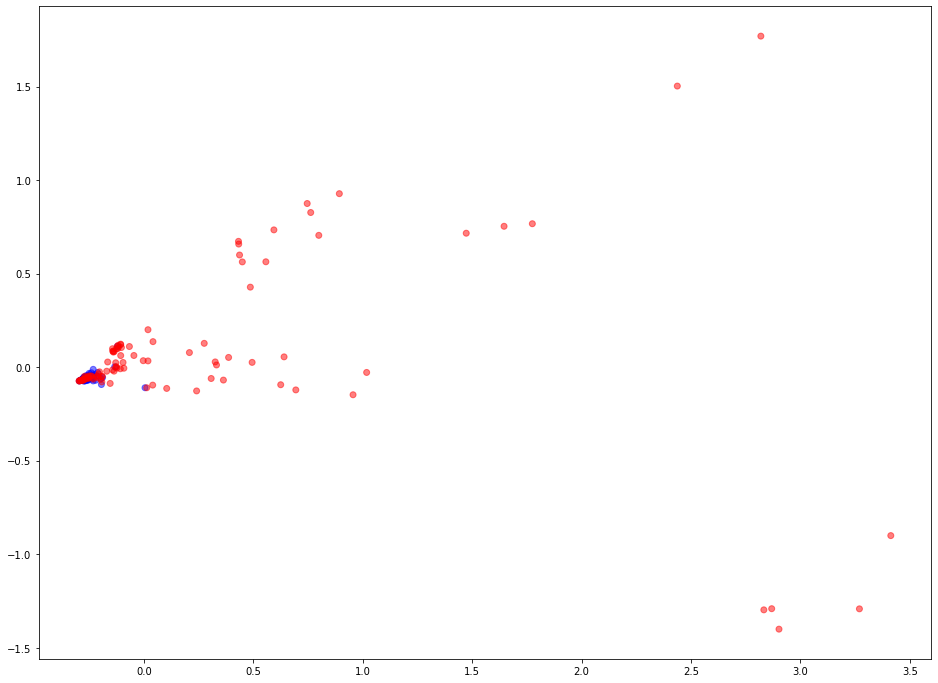

In [57]:
# Calculate edge features for test data
link_features = link_examples_to_features(
    examples_test, embedding_test, best_result["binary_operator"]
)

# Learn a projection from 128 dimensions to 2
pca = PCA(n_components=2)
X_transformed = pca.fit_transform(link_features)

# plot the 2-dimensional points
plt.figure(figsize=(16, 12))
plt.scatter(
    X_transformed[:, 0],
    X_transformed[:, 1],
    c=np.where(labels_test == 1, "b", "r"),
    alpha=0.5,
)

